In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import col, when, split
from pyspark.ml.feature import StringIndexer, Bucketizer
from pyspark.ml import Pipeline

In [2]:
spark=SparkSession.builder \
.master ("local[*]")\
.appName("part3")\
.config("spark.driver.memory", "8g")\
.config("spark.driver.cores", "4")\
.getOrCreate()

In [3]:
import os
os.getcwd()

'c:\\Users\\KourtniConnor\\Documents\\Fall23\\BAN\\smallproject2'

In [4]:
df=spark.read \
 .option("header","True")\
 .option("inferSchema","True")\
 .option("sep",";")\
 .csv("XYZ_Bank_Deposit_Data_Classification.csv")
print("There are",df.count(),"rows",len(df.columns),
      "columns" ,"in the data.") 

There are 41188 rows 21 columns in the data.


In [5]:
df.show(4)

+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
|age|      job|marital|  education|default|housing|loan|  contact|month|day_of_week|duration|campaign|pdays|previous|   poutcome|emp.var.rate|cons.price.idx|cons.conf.idx|euribor3m|nr.employed|  y|
+---+---------+-------+-----------+-------+-------+----+---------+-----+-----------+--------+--------+-----+--------+-----------+------------+--------------+-------------+---------+-----------+---+
| 56|housemaid|married|   basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 57| services|married|high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|  999|       0|nonexistent|         1.1|        93.994|        -36.4|    4.857|     5191.0| no|
| 37| serv

In [6]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day_of_week: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- emp.var.rate: double (nullable = true)
 |-- cons.price.idx: double (nullable = true)
 |-- cons.conf.idx: double (nullable = true)
 |-- euribor3m: double (nullable = true)
 |-- nr.employed: double (nullable = true)
 |-- y: string (nullable = true)



# handle 999 in pdays column

In [7]:

# Create a column to indicate pdays missing
df = df.withColumn('pdays_missing', when(col('pdays') == 999, 1).otherwise(0))

# Replace 999 with mean
mean_pdays = df.filter(col('pdays') != 999).agg({'pdays': 'mean'}).collect()[0][0]
df = df.withColumn('pdays', when(col('pdays') == 999, mean_pdays).otherwise(col('pdays')))

# EDA

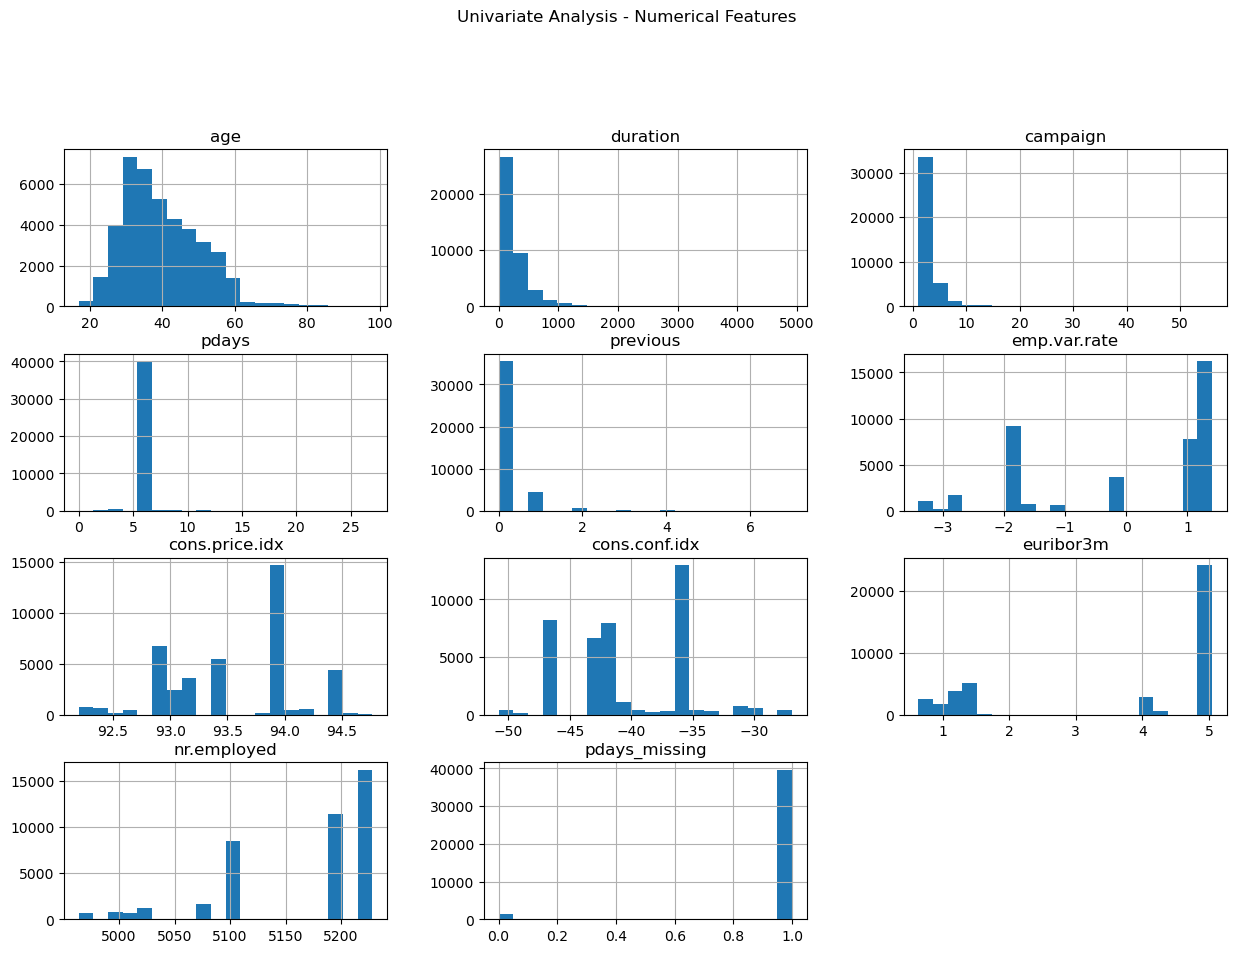

In [8]:
# Convert Spark DataFrame to Pandas DataFrame for plotting
df_pd = df.toPandas()

# Univariate analysis: Distribution of numerical features
numerical_features = df_pd.select_dtypes(include=['float64', 'int32'])
numerical_features.hist(bins=20, figsize=(15, 10))
plt.suptitle('Univariate Analysis - Numerical Features', y=1.02)
plt.show()

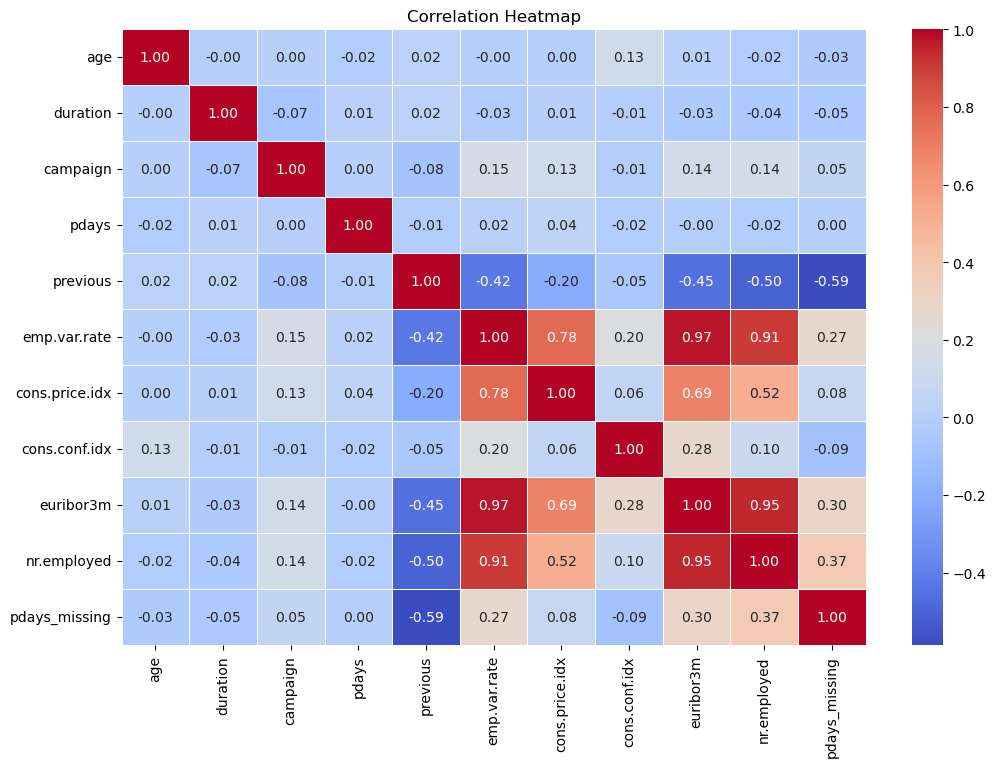

In [9]:
# Correlation heatmap for numerical features
correlation_matrix = numerical_features.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Drop Columns to avoid multicollinearity

In [10]:
# Assuming 'column1' and 'column2' are the names of the columns you want to drop
columns_to_drop = ['nr.employed', 'emp.var.rate']

df = df.drop(*columns_to_drop)


In [11]:
df.show()

+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------------+--------+-----------+--------------+-------------+---------+---+-------------+
|age|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|            pdays|previous|   poutcome|cons.price.idx|cons.conf.idx|euribor3m|  y|pdays_missing|
+---+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------------+--------+-----------+--------------+-------------+---------+---+-------------+
| 56|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|6.014521452145215|       0|nonexistent|        93.994|        -36.4|    4.857| no|            1|
| 57|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|6.014521452145215|       0|nonexistent|        

In [12]:
bin_edges = [0, 25, 35, 45, 55, 65, 100] 

# Use Bucketizer to create age bins
bucketizer = Bucketizer(splits=bin_edges, inputCol="age", outputCol="age_bin")
df = bucketizer.transform(df)

# Convert the bucketized age to string type
df = df.withColumn("age_bin", col("age_bin").cast("string"))

# Define the stages for the pipeline
stages = [
    StringIndexer(inputCol="age_bin", outputCol="age_group_index")
]

# Create a pipeline
pipeline = Pipeline(stages=stages)

In [13]:
# Fit and transform the pipeline
pipeline_model = pipeline.fit(df)
df = pipeline_model.transform(df)

# Drop unnecessary columns
columns_to_drop = ["age", "age_bin"]
df = df.drop(*columns_to_drop)

# Show the DataFrame after transformations
df.show()

+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------------+--------+-----------+--------------+-------------+---------+---+-------------+---------------+
|        job| marital|          education|default|housing|loan|  contact|month|day_of_week|duration|campaign|            pdays|previous|   poutcome|cons.price.idx|cons.conf.idx|euribor3m|  y|pdays_missing|age_group_index|
+-----------+--------+-------------------+-------+-------+----+---------+-----+-----------+--------+--------+-----------------+--------+-----------+--------------+-------------+---------+---+-------------+---------------+
|  housemaid| married|           basic.4y|     no|     no|  no|telephone|  may|        mon|     261|       1|6.014521452145215|       0|nonexistent|        93.994|        -36.4|    4.857| no|            1|            3.0|
|   services| married|        high.school|unknown|     no|  no|telephone|  may|        mon|     149|       1|6.0

In [14]:
df = df.withColumnRenamed('cons.conf.idx', 'cons_conf_idx')
df = df.withColumnRenamed('cons.price.idx', 'cons_price_idx')

In [15]:
columns_to_encode = ['y','job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Create a StringIndexer for each categorical column
indexers = [StringIndexer(inputCol=column, outputCol=column + "_index", handleInvalid="keep") for column in columns_to_encode]

# Assemble the stages into a pipeline
pipeline = Pipeline(stages=indexers)

# Fit and transform the pipeline
model = pipeline.fit(df)
df_encoded = model.transform(df)

# Drop the original categorical columns
columns_to_drop = columns_to_encode
df_encoded = df_encoded.drop(*columns_to_drop)

In [16]:
df_encoded.show()

+--------+--------+-----------------+--------+--------------+-------------+---------+-------------+---------------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|duration|campaign|            pdays|previous|cons_price_idx|cons_conf_idx|euribor3m|pdays_missing|age_group_index|y_index|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|
+--------+--------+-----------------+--------+--------------+-------------+---------+-------------+---------------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+
|     261|       1|6.014521452145215|       0|        93.994|        -36.4|    4.857|            1|            3.0|    0.0|      8.0|          0.0|            4.0|          0.0|          1.0|       0.0|          1.

In [17]:
column_name = "duration"

min_value = df_encoded.agg({column_name: "min"}).collect()[0]
max_value = df_encoded.agg({column_name: "max"}).collect()[0]

In [18]:
print(min_value)
print(max_value)

Row(min(duration)=0)
Row(max(duration)=4918)


In [19]:
bin_edges = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000] 

# Use Bucketizer to create duration bins
bucketizer = Bucketizer(splits=bin_edges, inputCol="duration", outputCol="duration_bin")
df_encoded = bucketizer.transform(df_encoded)

# Define the stages for the pipeline
stages = [
    StringIndexer(inputCol="duration_bin", outputCol="duration_group_index")
]

# Create a pipeline
pipeline = Pipeline(stages=stages)

# Fit and transform the pipeline
pipeline_model = pipeline.fit(df_encoded)
df_encoded = pipeline_model.transform(df_encoded)

# Drop unnecessary columns
columns_to_drop = ["duration", "duration_bin"]
df_encoded = df_encoded.drop(*columns_to_drop)

# Show the DataFrame after transformations
df_encoded.show()

+--------+-----------------+--------+--------------+-------------+---------+-------------+---------------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+
|campaign|            pdays|previous|cons_price_idx|cons_conf_idx|euribor3m|pdays_missing|age_group_index|y_index|job_index|marital_index|education_index|default_index|housing_index|loan_index|contact_index|month_index|day_of_week_index|poutcome_index|duration_group_index|
+--------+-----------------+--------+--------------+-------------+---------+-------------+---------------+-------+---------+-------------+---------------+-------------+-------------+----------+-------------+-----------+-----------------+--------------+--------------------+
|       1|6.014521452145215|       0|        93.994|        -36.4|    4.857|            1|            3.0|    0.0|      8.0|          0.0|            4.0|          0.0|          

In [20]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler


feature_cols = [col for col in df_encoded.columns if col != 'y_index']


assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
spark_df = assembler.transform(df_encoded)

lr = LogisticRegression(maxIter=1500, labelCol='y_index')

# Split the data into training and testing sets
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=0)

# Train the model
model = lr.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='y_index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Print the classification report
print("Accuracy: {:.2%}".format(accuracy))



Accuracy: 90.45%


# Smote for imbalanced target variable

# LR After SMOTE

# Random Forrest

In [21]:
from pyspark.ml.classification import RandomForestClassifier

feature_cols = [col for col in df_encoded.columns if col != 'y_index']

# Apply the VectorAssembler to your data
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
spark_df = assembler.transform(df_encoded)

# Train a RandomForestClassifier
rf = RandomForestClassifier(labelCol='y_index', seed=42)

# Split the data into training and testing sets
train_data, test_data = spark_df.randomSplit([0.7, 0.3], seed=0)

# Train the model
model = rf.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol='y_index', predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)

# Print the classification report
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 89.75%


In [22]:
# Get feature importances
feature_importances = model.featureImportances

# Convert feature importances to a list
importances_list = feature_importances.toArray().tolist()

# Create a DataFrame to display feature importances
feature_importance_df = spark.createDataFrame(zip(feature_cols, importances_list), ["Feature", "Importance"])

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort('Importance', ascending=False)

feature_importance_df.show()

Py4JJavaError: An error occurred while calling o1254.showString.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 129.0 failed 1 times, most recent failure: Lost task 7.0 in stage 129.0 (TID 207) (DESKTOP-DD0F0TV.attlocal.net executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:551)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:519)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 35 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2493)
	at org.apache.spark.rdd.RDD.$anonfun$reduce$1(RDD.scala:1136)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.reduce(RDD.scala:1118)
	at org.apache.spark.rdd.RDD.$anonfun$takeOrdered$1(RDD.scala:1565)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.takeOrdered(RDD.scala:1552)
	at org.apache.spark.sql.execution.TakeOrderedAndProjectExec.executeCollect(limit.scala:291)
	at org.apache.spark.sql.Dataset.collectFromPlan(Dataset.scala:4344)
	at org.apache.spark.sql.Dataset.$anonfun$head$1(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.head(Dataset.scala:3326)
	at org.apache.spark.sql.Dataset.take(Dataset.scala:3549)
	at org.apache.spark.sql.Dataset.getRows(Dataset.scala:280)
	at org.apache.spark.sql.Dataset.showString(Dataset.scala:315)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:551)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:519)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 35 more


In [ ]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator


feature_cols = [col for col in df_encoded.columns if col != 'y_index']


assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
df_assembled = assembler.transform(df_encoded)

# Standardize the feature matrix
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
scalerModel = scaler.fit(df_assembled)
df_scaled = scalerModel.transform(df_assembled)

# Initialize the ClusteringEvaluator
evaluator = ClusteringEvaluator(featuresCol='scaledFeatures')

# Determine the optimal number of clusters using the elbow method
cost = []  # Silhouette scores
for k in range(2, 10):
    kmeans = KMeans().setK(k).setSeed(42).setFeaturesCol('scaledFeatures')
    model = kmeans.fit(df_scaled)
    predictions = model.transform(df_scaled)
    silhouette = evaluator.evaluate(predictions)
    cost.append(silhouette)

# Print the Silhouette score for each k
for i in range(2, 10):
    print(f"The Silhouette score for k={i} is {cost[i-2]}")

# Based on the elbow method, choose the optimal number of clusters
optimal_k = 4  # Adjust based on the cost

# Apply k-means clustering with the chosen number of clusters
kmeans = KMeans().setK(optimal_k).setSeed(42).setFeaturesCol('scaledFeatures')
model = kmeans.fit(df_scaled)

# Add the cluster labels to the original dataset
predictions = model.transform(df_scaled)

# Evaluate the model
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

The Silhouette score for k=2 is 0.47731375985416963
The Silhouette score for k=3 is 0.12333900312970406
The Silhouette score for k=4 is 0.15826284941373508
The Silhouette score for k=5 is 0.20418133621534829
The Silhouette score for k=6 is 0.1724777647921601
The Silhouette score for k=7 is 0.17735892118134594
The Silhouette score for k=8 is 0.19360906391051236
The Silhouette score for k=9 is 0.16619625345124323
Silhouette with squared euclidean distance = 0.15826284941373508


In [24]:
model.save("c:/Users/KourtniConnor/Documents/Fall23/BAN/smallproject2/lr_model")

Py4JJavaError: An error occurred while calling o1360.save.
: org.apache.spark.SparkException: Job aborted.
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:106)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1091)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopDataset(PairRDDFunctions.scala:1089)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$4(PairRDDFunctions.scala:1062)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1027)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$3(PairRDDFunctions.scala:1009)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:1008)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopFile$2(PairRDDFunctions.scala:965)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.PairRDDFunctions.saveAsHadoopFile(PairRDDFunctions.scala:963)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$2(RDD.scala:1620)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1620)
	at org.apache.spark.rdd.RDD.$anonfun$saveAsTextFile$1(RDD.scala:1606)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.saveAsTextFile(RDD.scala:1606)
	at org.apache.spark.ml.util.DefaultParamsWriter$.saveMetadata(ReadWrite.scala:413)
	at org.apache.spark.ml.tree.EnsembleModelReadWrite$.saveImpl(treeModels.scala:473)
	at org.apache.spark.ml.classification.RandomForestClassificationModel$RandomForestClassificationModelWriter.saveImpl(RandomForestClassifier.scala:413)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:168)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:834)
Caused by: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Ljava/lang/String;I)Z
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access0(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$Windows.access(NativeIO.java:793)
	at org.apache.hadoop.fs.FileUtil.canRead(FileUtil.java:1249)
	at org.apache.hadoop.fs.FileUtil.list(FileUtil.java:1454)
	at org.apache.hadoop.fs.RawLocalFileSystem.listStatus(RawLocalFileSystem.java:601)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.fs.ChecksumFileSystem.listStatus(ChecksumFileSystem.java:761)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:1972)
	at org.apache.hadoop.fs.FileSystem.listStatus(FileSystem.java:2014)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.getAllCommittedTaskPaths(FileOutputCommitter.java:334)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJobInternal(FileOutputCommitter.java:404)
	at org.apache.hadoop.mapreduce.lib.output.FileOutputCommitter.commitJob(FileOutputCommitter.java:377)
	at org.apache.hadoop.mapred.FileOutputCommitter.commitJob(FileOutputCommitter.java:136)
	at org.apache.hadoop.mapred.OutputCommitter.commitJob(OutputCommitter.java:291)
	at org.apache.spark.internal.io.HadoopMapReduceCommitProtocol.commitJob(HadoopMapReduceCommitProtocol.scala:192)
	at org.apache.spark.internal.io.SparkHadoopWriter$.$anonfun$write$3(SparkHadoopWriter.scala:100)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.util.Utils$.timeTakenMs(Utils.scala:552)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:100)
	... 52 more
